<a href="https://colab.research.google.com/github/Lorenzo-B/chaos-biocv/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libaries

In [ ]:
%pip install pydicom

In [2]:
import tensorflow as tf
import keras as keras
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Clone Dataset

In [ ]:
!git clone https://github.com/Lorenzo-B/chaos-biocv.git

In [ ]:
%cd chaos-biocv/chaos_dataset/
!tfds build
%cd /content/

In [5]:
dataset, info = tfds.load('chaos_dataset:1.0.12', with_info=True)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = TRAIN_LENGTH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Load Dataset

## Preprocessing and data Augmentation

In [6]:
def resize(input_image: tf.Tensor, input_mask: tf.Tensor):
   input_image = tf.image.resize(input_image, (128, 128))
   input_mask = tf.image.resize(input_mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

   return input_image, input_mask

def normalize(input_image: tf.Tensor, input_mask: tf.Tensor):
   return input_image, input_mask

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.

        self.augment_inputs = keras.layers.RandomFlip(mode="vertical", seed=seed)
        self.augment_masks = keras.layers.RandomFlip(mode="vertical", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_masks(labels)
        return inputs, labels


def load_image(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]

   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask


## Prepare dataset

In [7]:
train_dataset = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_batches = validation_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

# Helper functions

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        # plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis('off')
    plt.show()

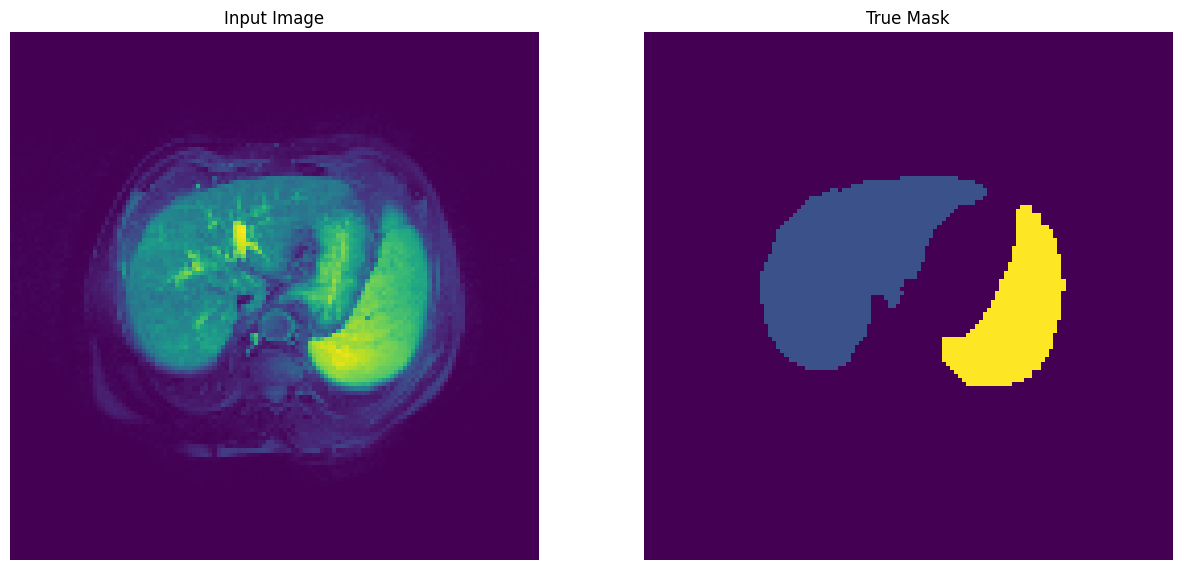

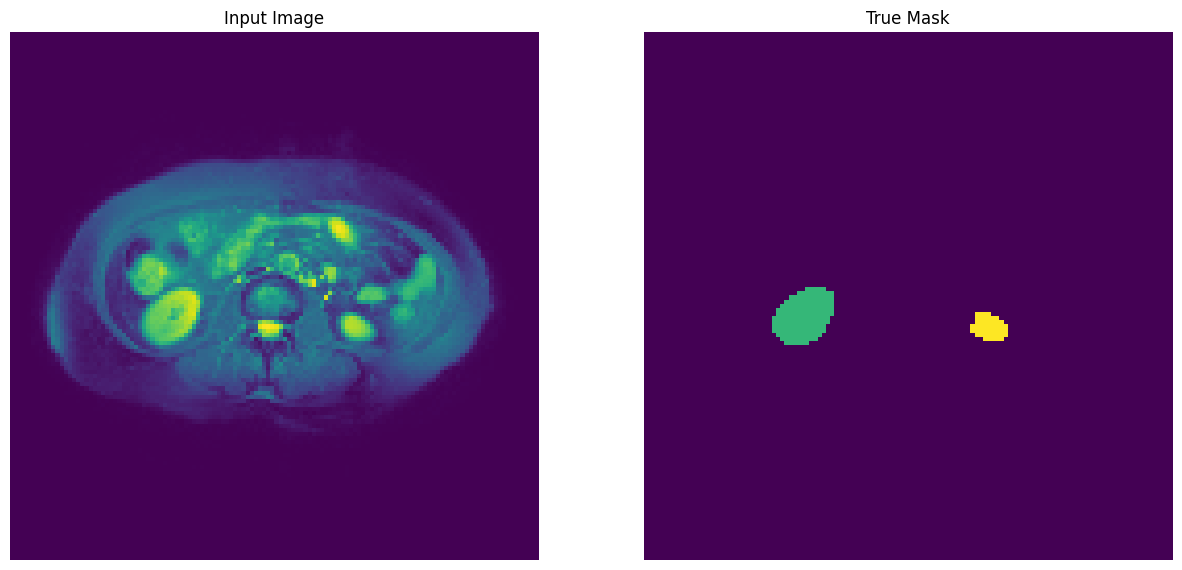

In [10]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# U-Net Model

In [11]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = keras.layers.MaxPool2D(2)(f)
    p = keras.layers.Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = keras.layers.concatenate([x, conv_features])
    # dropout
    x = keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [12]:
def build_unet_model():

    # inputs
    inputs = keras.layers.Input(shape=(128,128,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # last = tf.keras.layers.Conv2DTranspose(
    #   filters=5, kernel_size=3, strides=2,
    #   padding='same')  #64x64 -> 128x128
    # outputs = last(u9)

    # outputs
    outputs = keras.layers.Conv2D(filters=5, kernel_size=1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [13]:
unet_model = build_unet_model()

In [14]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [15]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [17]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

## Predictions (before training)

1/1 [==============================] - 5s 5s/step


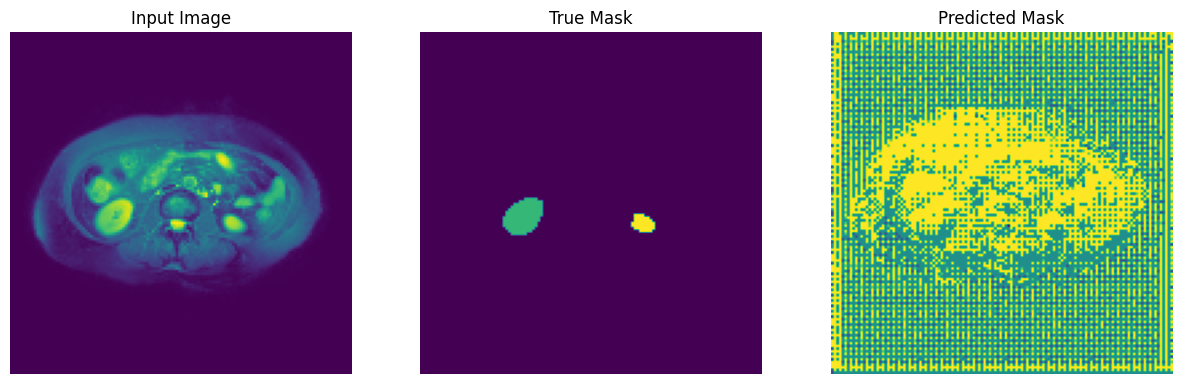

In [18]:
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [20]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0, 5.0, 6.0, 6.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

## Training

Epoch 1/20
 6/35 [====>.........................] - ETA: 14s - loss: 0.0618 - accuracy: 0.7157

35/35 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.8634
Epoch 1: loss improved from inf to 0.03074, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


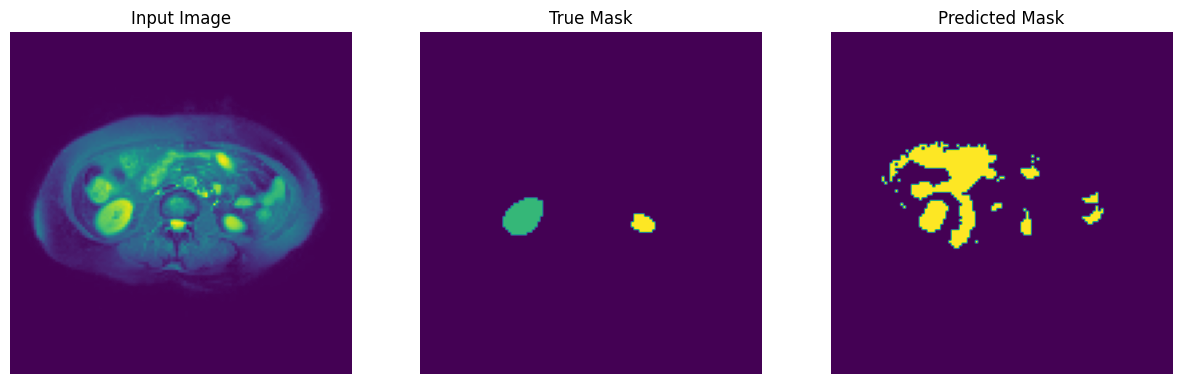


Sample Prediction after epoch 1

35/35 [==============================] - 56s 611ms/step - loss: 0.0307 - accuracy: 0.8634 - val_loss: 0.1842 - val_accuracy: 0.9500
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9212
Epoch 2: loss improved from 0.03074 to 0.01969, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 33ms/step


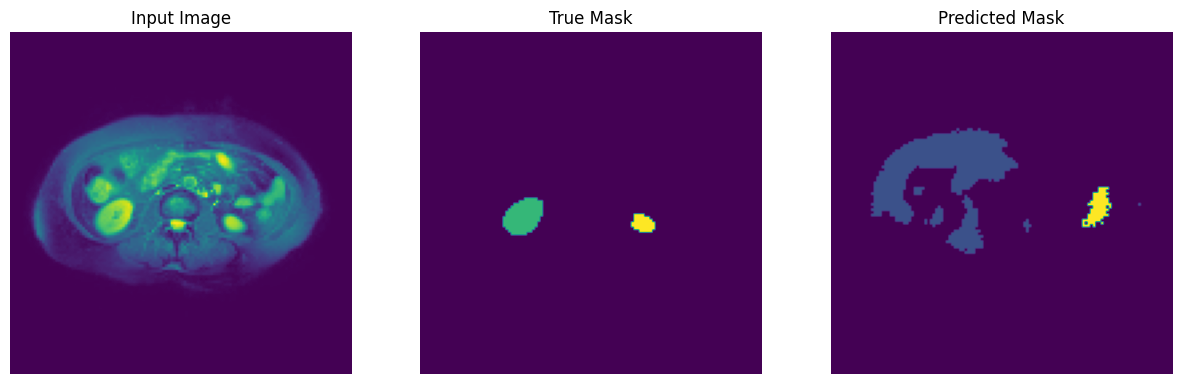


Sample Prediction after epoch 2

35/35 [==============================] - 39s 594ms/step - loss: 0.0197 - accuracy: 0.9212 - val_loss: 0.1932 - val_accuracy: 0.9467
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9360
Epoch 3: loss improved from 0.01969 to 0.01434, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


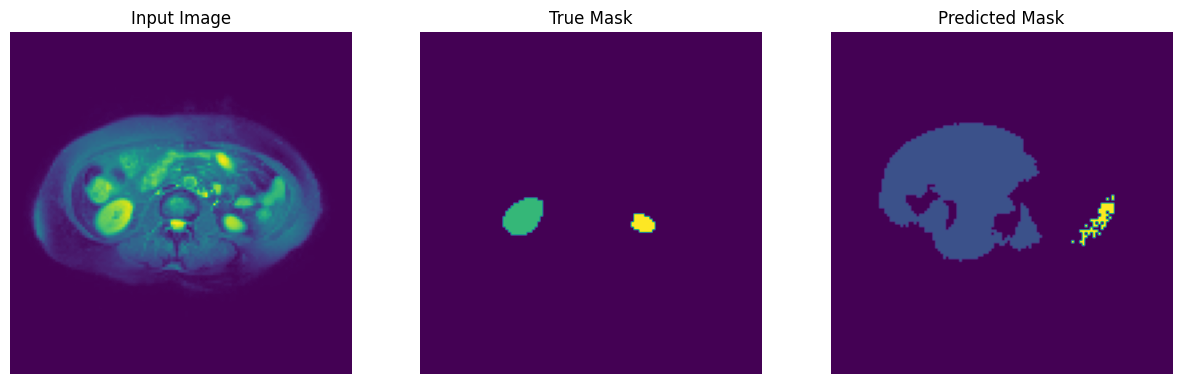


Sample Prediction after epoch 3

35/35 [==============================] - 20s 585ms/step - loss: 0.0143 - accuracy: 0.9360 - val_loss: 0.2452 - val_accuracy: 0.9213
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9372
Epoch 4: loss improved from 0.01434 to 0.01196, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 28ms/step


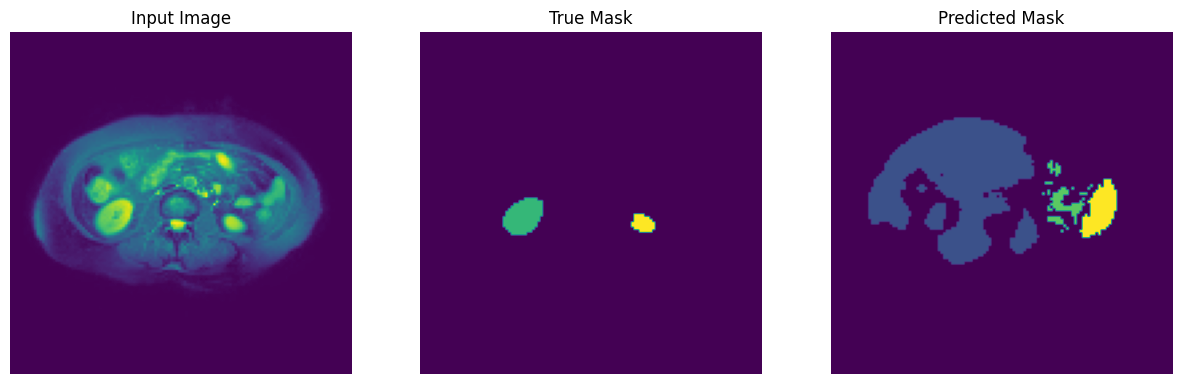


Sample Prediction after epoch 4

35/35 [==============================] - 21s 596ms/step - loss: 0.0120 - accuracy: 0.9372 - val_loss: 0.2552 - val_accuracy: 0.9013
Epoch 5/20
35/35 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9413
Epoch 5: loss improved from 0.01196 to 0.01071, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 20ms/step


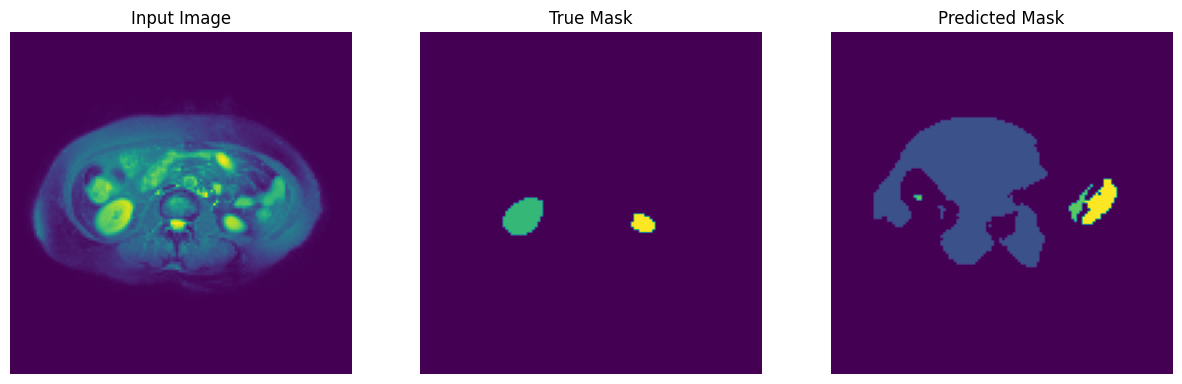


Sample Prediction after epoch 5

35/35 [==============================] - 21s 589ms/step - loss: 0.0107 - accuracy: 0.9413 - val_loss: 0.2485 - val_accuracy: 0.9027
Epoch 6/20
35/35 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9435
Epoch 6: loss improved from 0.01071 to 0.00946, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 34ms/step


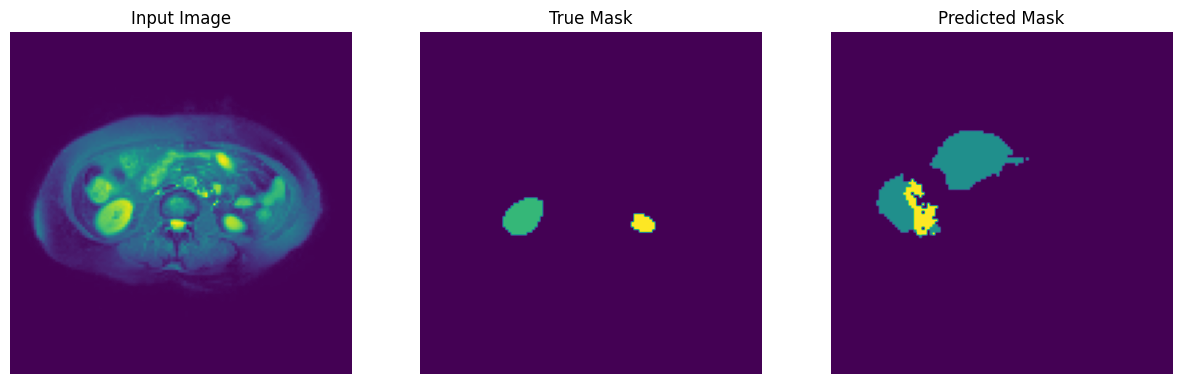


Sample Prediction after epoch 6

35/35 [==============================] - 21s 593ms/step - loss: 0.0095 - accuracy: 0.9435 - val_loss: 0.1492 - val_accuracy: 0.9370
Epoch 7/20
35/35 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9456
Epoch 7: loss improved from 0.00946 to 0.00898, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 20ms/step


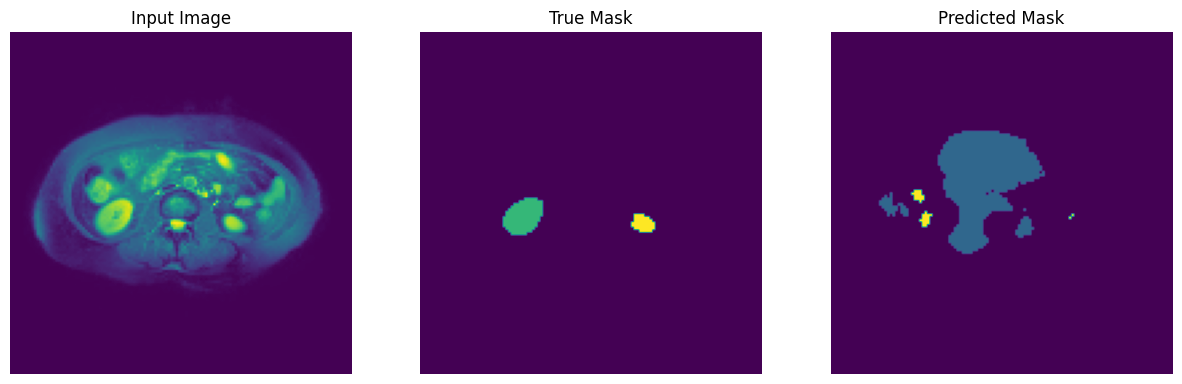


Sample Prediction after epoch 7

35/35 [==============================] - 21s 594ms/step - loss: 0.0090 - accuracy: 0.9456 - val_loss: 0.1484 - val_accuracy: 0.9405
Epoch 8/20
35/35 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9507
Epoch 8: loss improved from 0.00898 to 0.00809, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 21ms/step


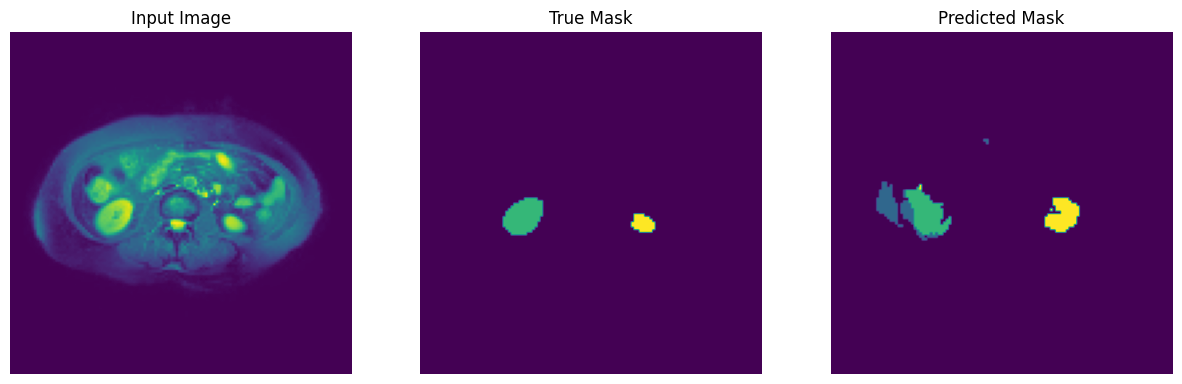


Sample Prediction after epoch 8

35/35 [==============================] - 20s 580ms/step - loss: 0.0081 - accuracy: 0.9507 - val_loss: 0.1299 - val_accuracy: 0.9443
Epoch 9/20
35/35 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9558
Epoch 9: loss improved from 0.00809 to 0.00726, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 23ms/step


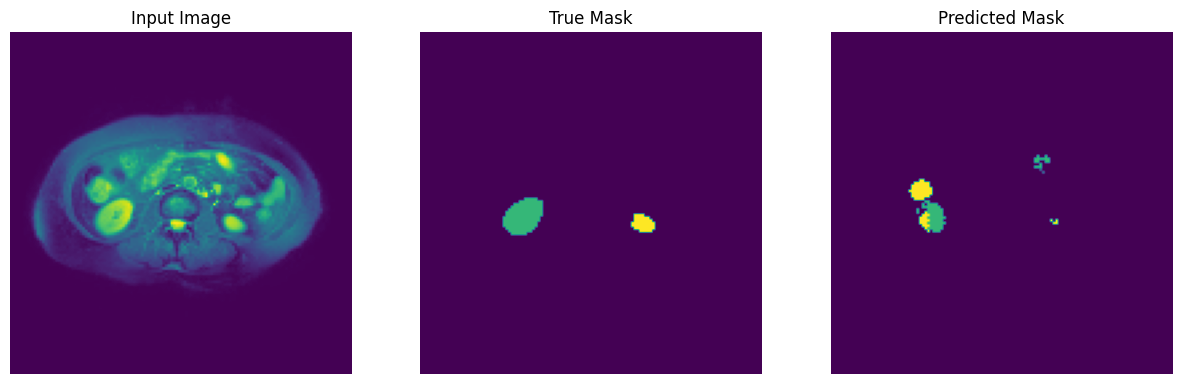


Sample Prediction after epoch 9

35/35 [==============================] - 21s 596ms/step - loss: 0.0073 - accuracy: 0.9558 - val_loss: 0.0789 - val_accuracy: 0.9707
Epoch 10/20
35/35 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9517
Epoch 10: loss did not improve from 0.00726
1/1 [==============================] - 0s 21ms/step


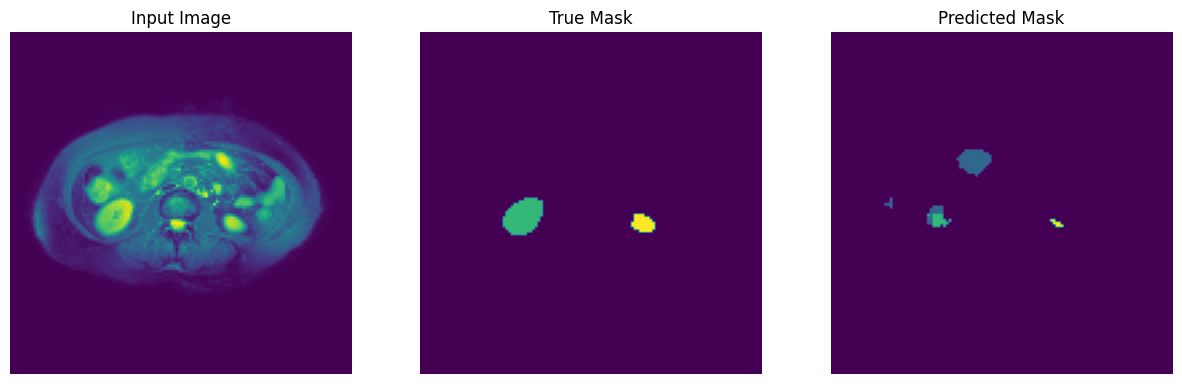


Sample Prediction after epoch 10

35/35 [==============================] - 18s 521ms/step - loss: 0.0084 - accuracy: 0.9517 - val_loss: 0.1028 - val_accuracy: 0.9626
Epoch 11/20
35/35 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9545
Epoch 11: loss improved from 0.00726 to 0.00722, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


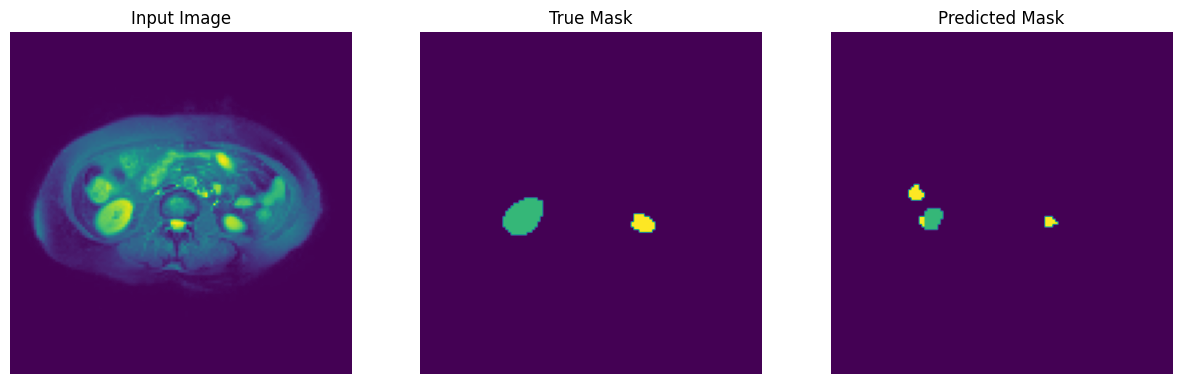


Sample Prediction after epoch 11

35/35 [==============================] - 23s 661ms/step - loss: 0.0072 - accuracy: 0.9545 - val_loss: 0.0662 - val_accuracy: 0.9757
Epoch 12/20
35/35 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9636
Epoch 12: loss improved from 0.00722 to 0.00602, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 22ms/step


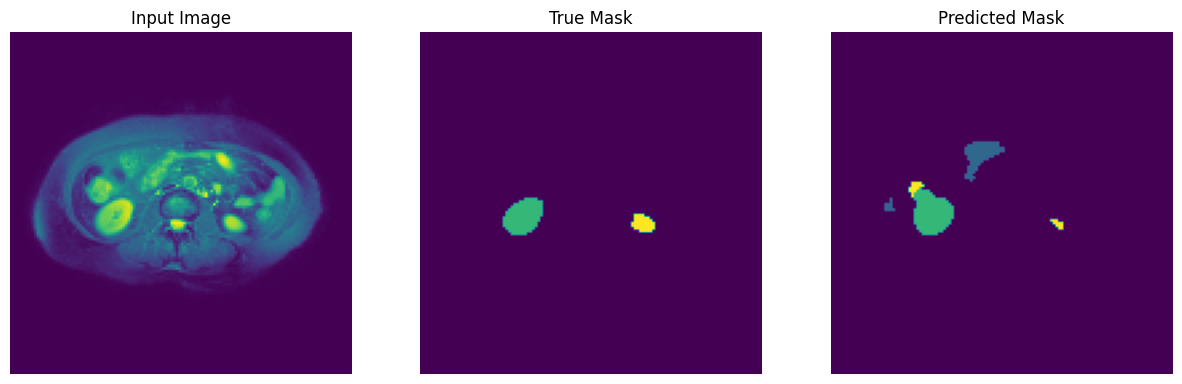


Sample Prediction after epoch 12

35/35 [==============================] - 20s 579ms/step - loss: 0.0060 - accuracy: 0.9636 - val_loss: 0.0868 - val_accuracy: 0.9688
Epoch 13/20
35/35 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9638
Epoch 13: loss improved from 0.00602 to 0.00570, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 20ms/step


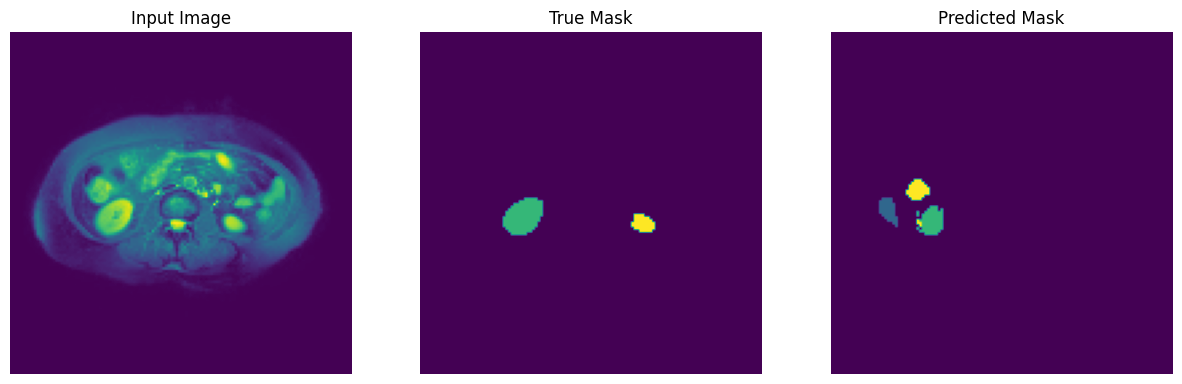


Sample Prediction after epoch 13

35/35 [==============================] - 21s 601ms/step - loss: 0.0057 - accuracy: 0.9638 - val_loss: 0.0701 - val_accuracy: 0.9727
Epoch 14/20
35/35 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9690
Epoch 14: loss improved from 0.00570 to 0.00512, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


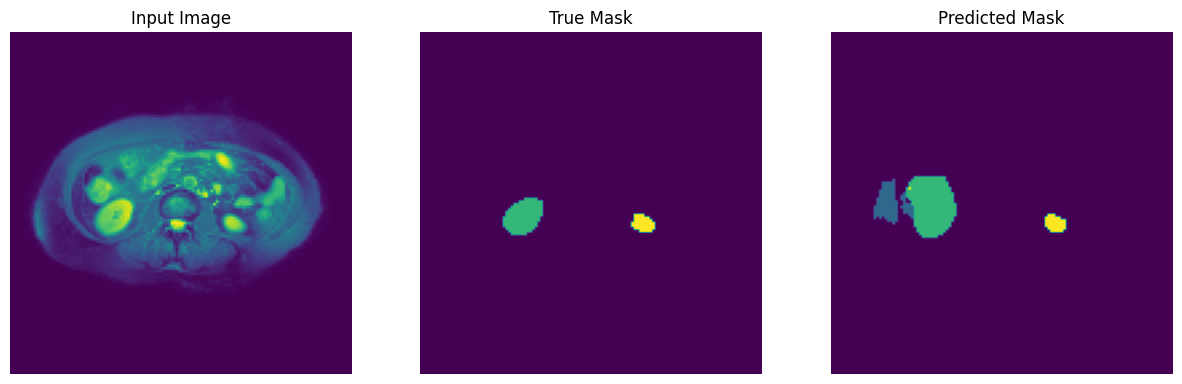


Sample Prediction after epoch 14

35/35 [==============================] - 21s 590ms/step - loss: 0.0051 - accuracy: 0.9690 - val_loss: 0.1099 - val_accuracy: 0.9609
Epoch 15/20
35/35 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9728
Epoch 15: loss improved from 0.00512 to 0.00431, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


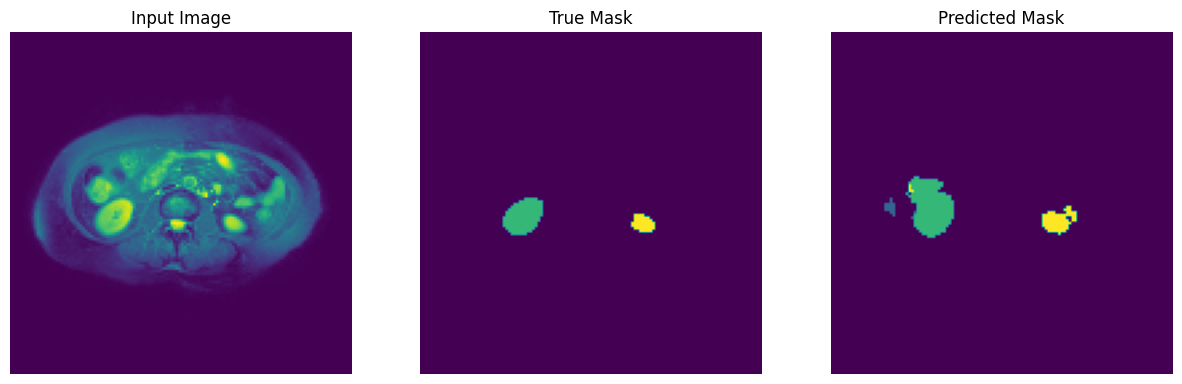


Sample Prediction after epoch 15

35/35 [==============================] - 21s 595ms/step - loss: 0.0043 - accuracy: 0.9728 - val_loss: 0.0782 - val_accuracy: 0.9679
Epoch 16/20
35/35 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9750
Epoch 16: loss improved from 0.00431 to 0.00399, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 19ms/step


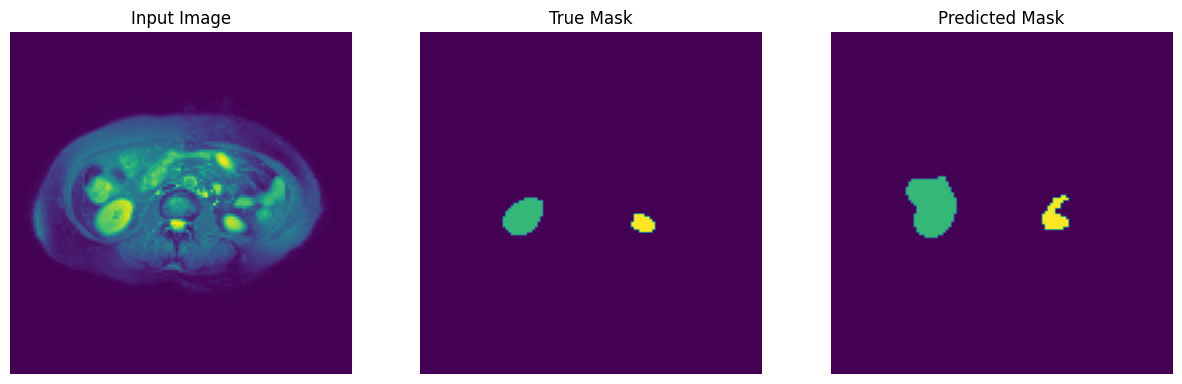


Sample Prediction after epoch 16

35/35 [==============================] - 20s 582ms/step - loss: 0.0040 - accuracy: 0.9750 - val_loss: 0.0756 - val_accuracy: 0.9709
Epoch 17/20
35/35 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9766
Epoch 17: loss improved from 0.00399 to 0.00352, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 30ms/step


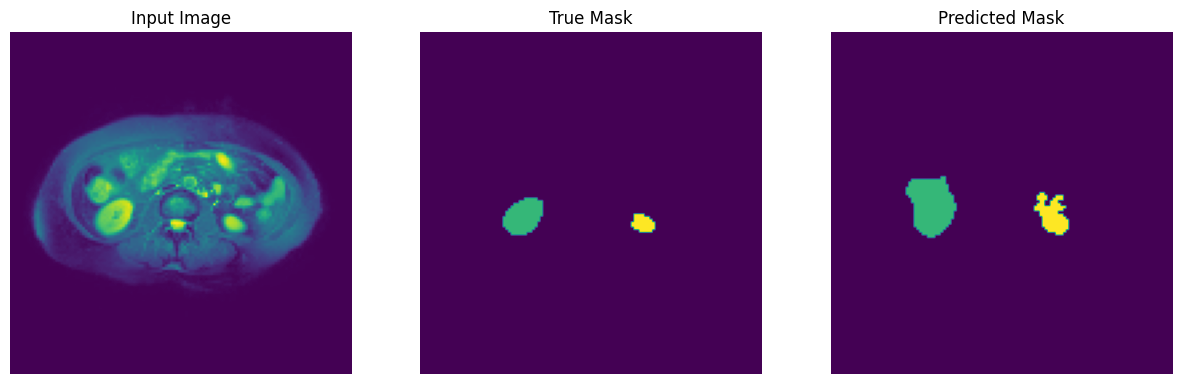


Sample Prediction after epoch 17

35/35 [==============================] - 21s 607ms/step - loss: 0.0035 - accuracy: 0.9766 - val_loss: 0.0644 - val_accuracy: 0.9749
Epoch 18/20
35/35 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9789
Epoch 18: loss improved from 0.00352 to 0.00334, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 20ms/step


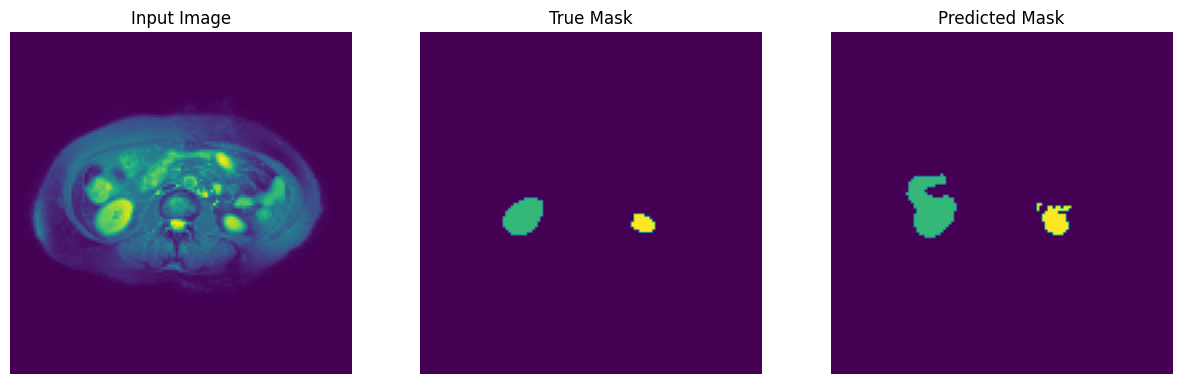


Sample Prediction after epoch 18

35/35 [==============================] - 20s 582ms/step - loss: 0.0033 - accuracy: 0.9789 - val_loss: 0.0587 - val_accuracy: 0.9783
Epoch 19/20
35/35 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9778
Epoch 19: loss did not improve from 0.00334
1/1 [==============================] - 0s 26ms/step


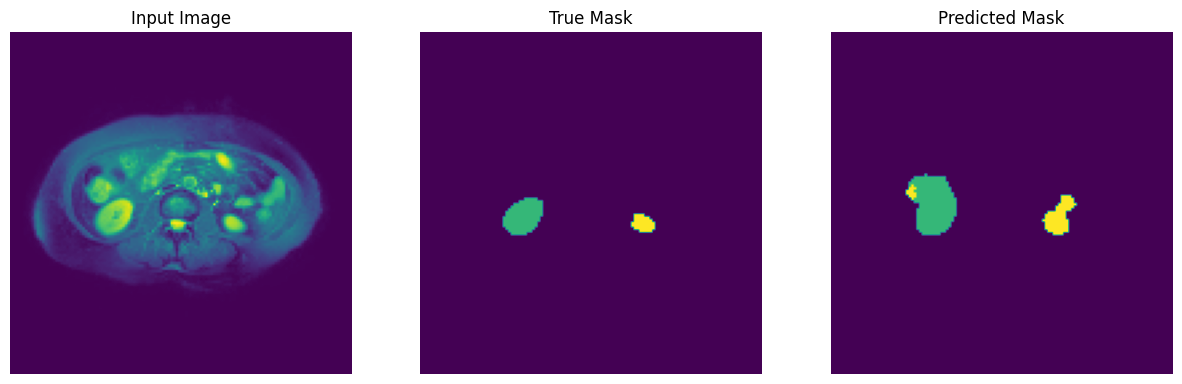


Sample Prediction after epoch 19

35/35 [==============================] - 18s 521ms/step - loss: 0.0034 - accuracy: 0.9778 - val_loss: 0.0679 - val_accuracy: 0.9750
Epoch 20/20
35/35 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9809
Epoch 20: loss improved from 0.00334 to 0.00291, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 26ms/step


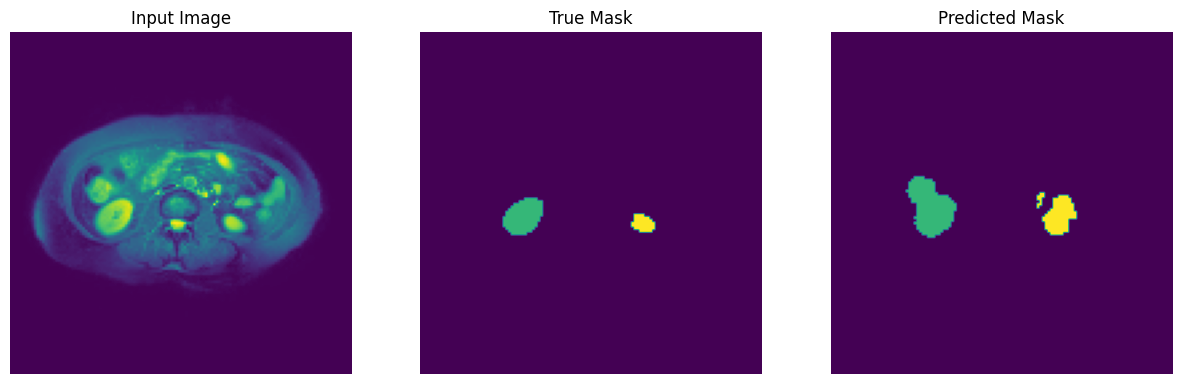


Sample Prediction after epoch 20

35/35 [==============================] - 20s 586ms/step - loss: 0.0029 - accuracy: 0.9809 - val_loss: 0.0574 - val_accuracy: 0.9796


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['validation'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_checkpoint = ModelCheckpoint('chaos19_unet.keras', monitor='loss', verbose=1, save_best_only = True)
model_history = unet_model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches,
                          callbacks=[model_checkpoint, DisplayCallback()])

# Training and validation loss

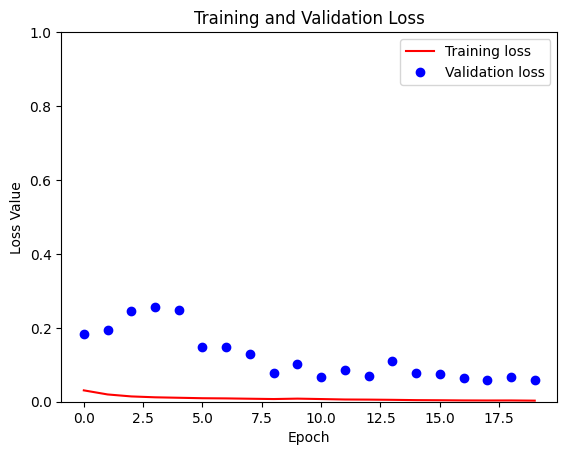

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Predictions

1/1 [==============================] - 0s 159ms/step


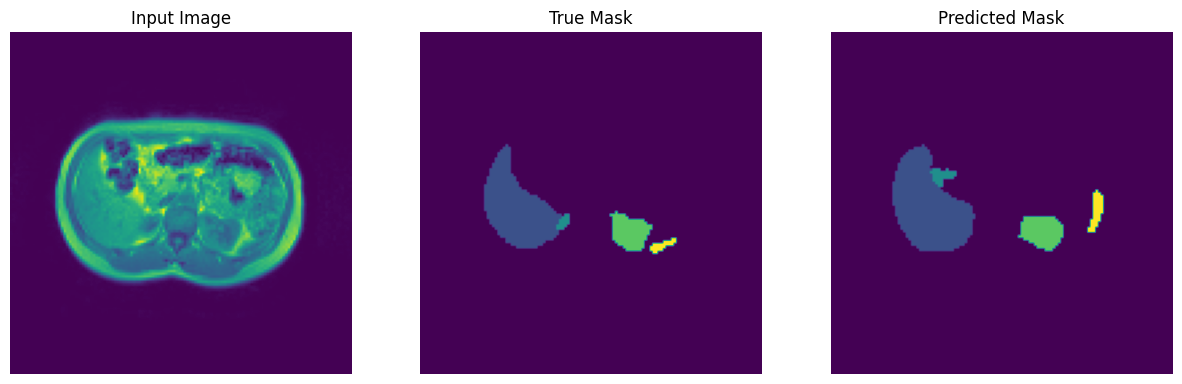

1/1 [==============================] - 0s 95ms/step


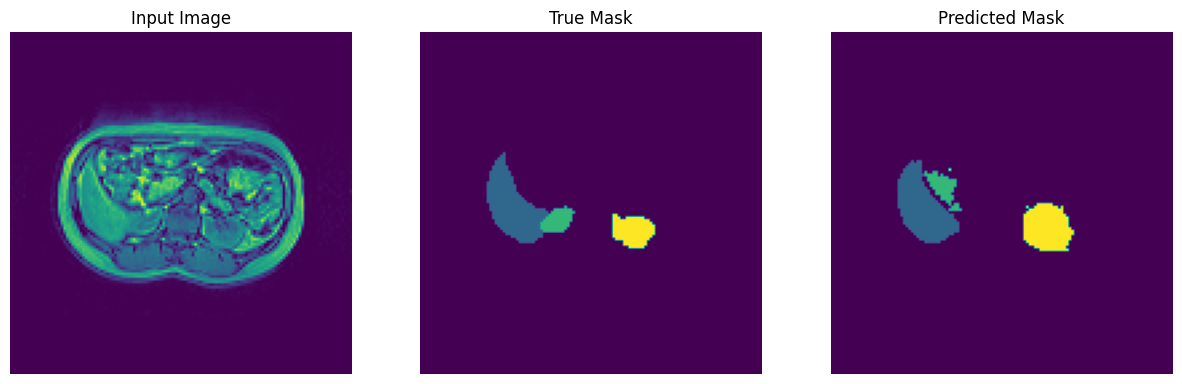

1/1 [==============================] - 0s 82ms/step


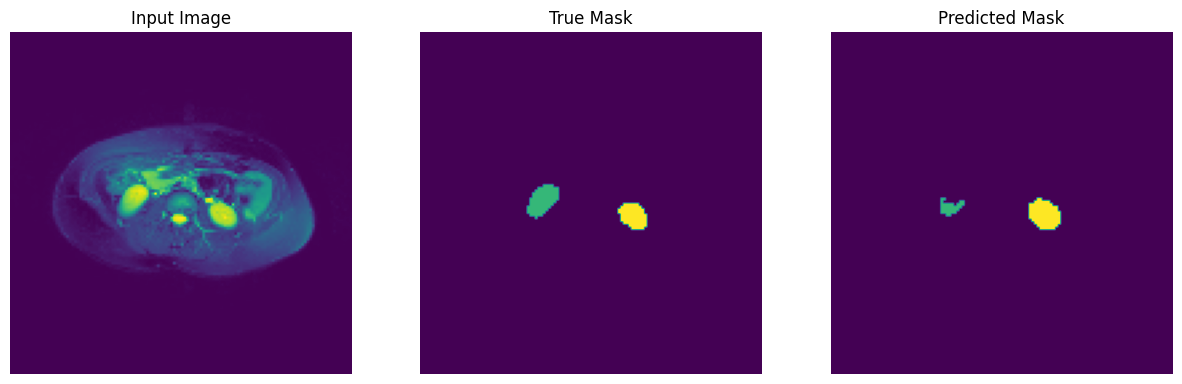

1/1 [==============================] - 0s 28ms/step


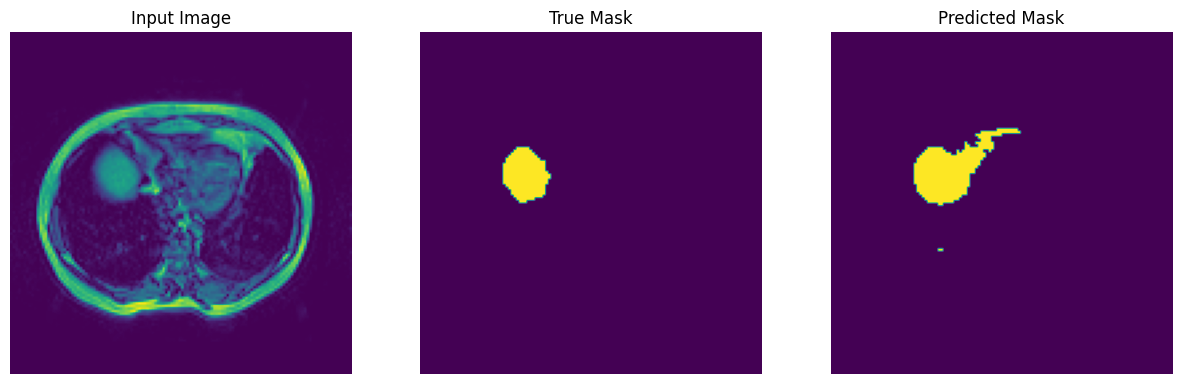

1/1 [==============================] - 0s 40ms/step


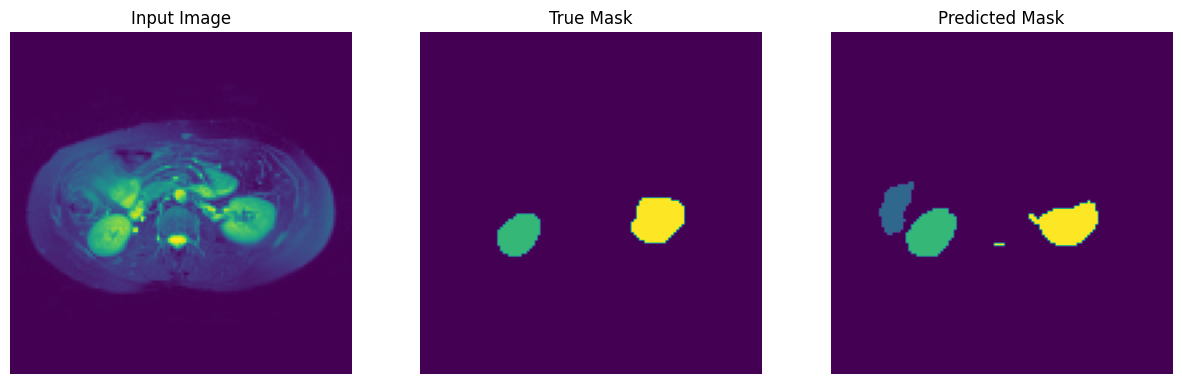

1/1 [==============================] - 0s 31ms/step


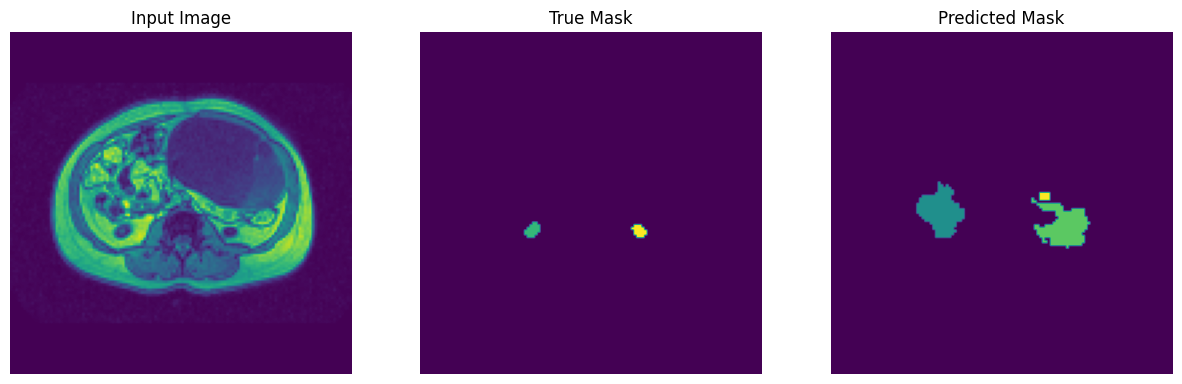

1/1 [==============================] - 0s 43ms/step


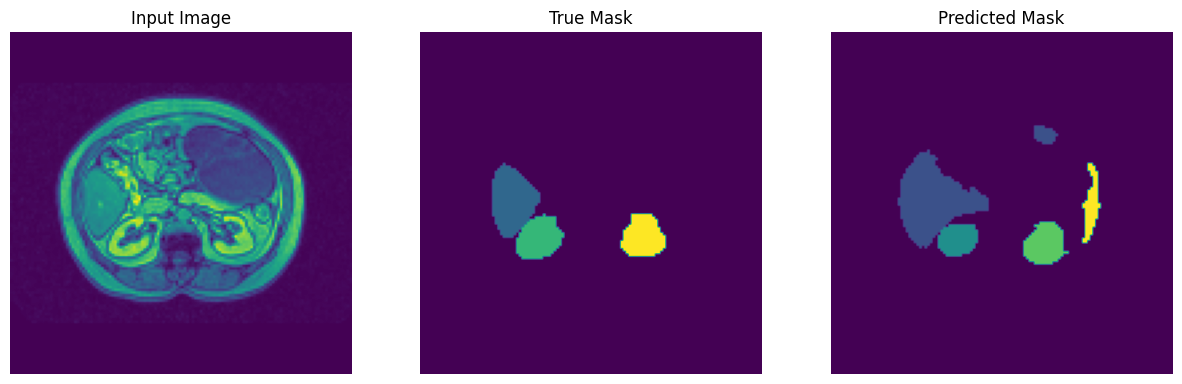

1/1 [==============================] - 0s 58ms/step


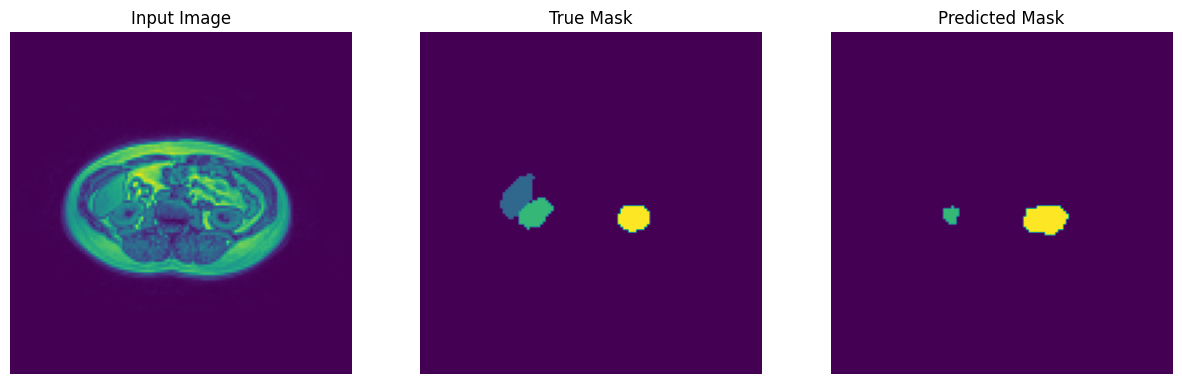

1/1 [==============================] - 0s 19ms/step


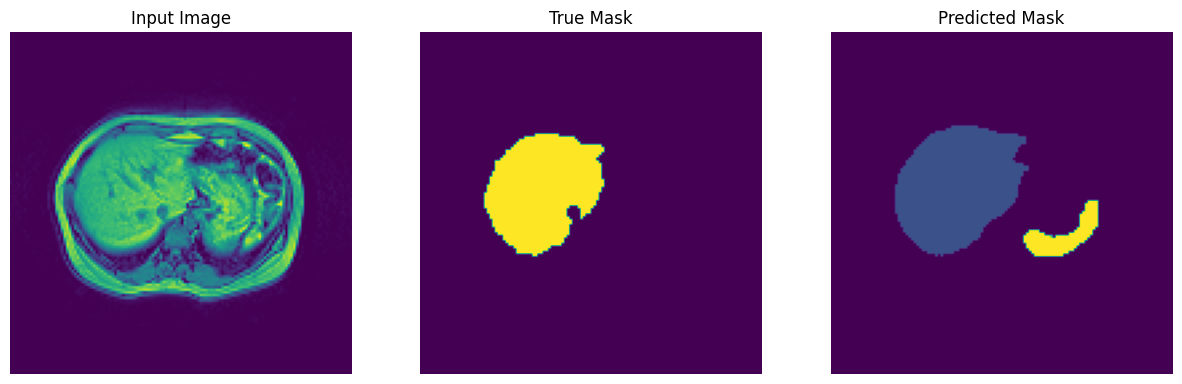

1/1 [==============================] - 0s 22ms/step


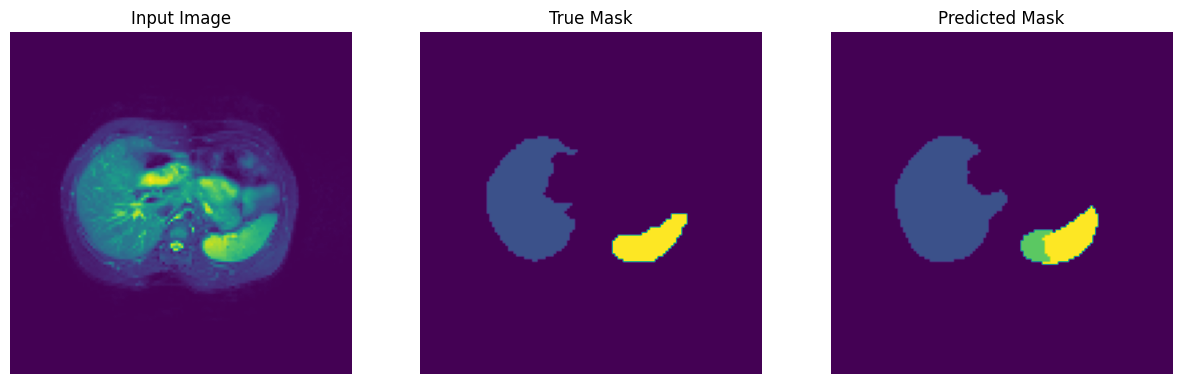

1/1 [==============================] - 0s 19ms/step


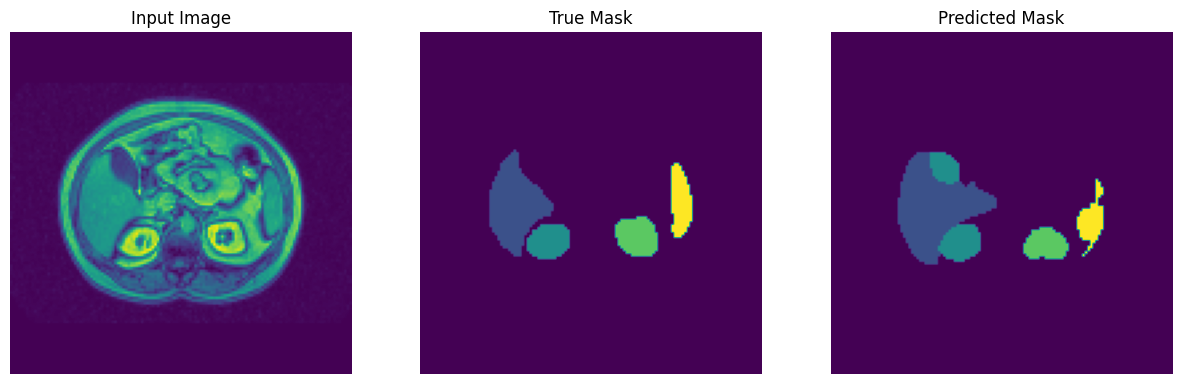

1/1 [==============================] - 0s 34ms/step


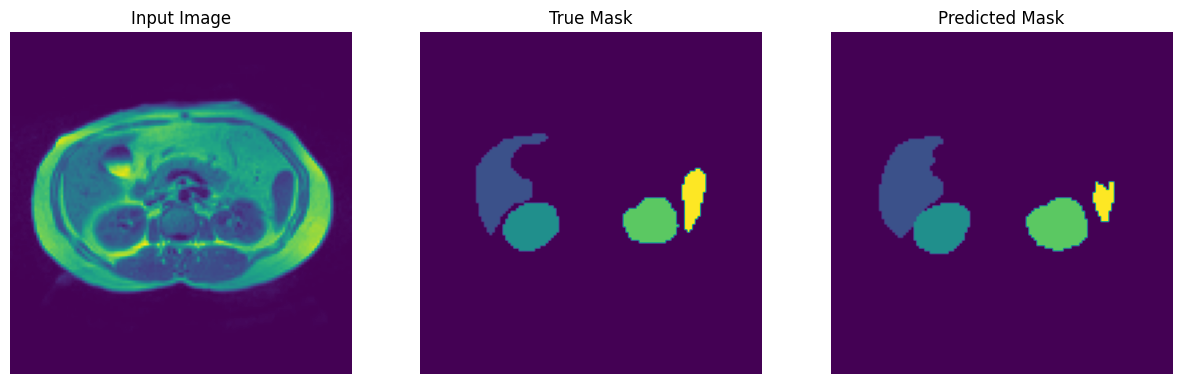

1/1 [==============================] - 3s 3s/step


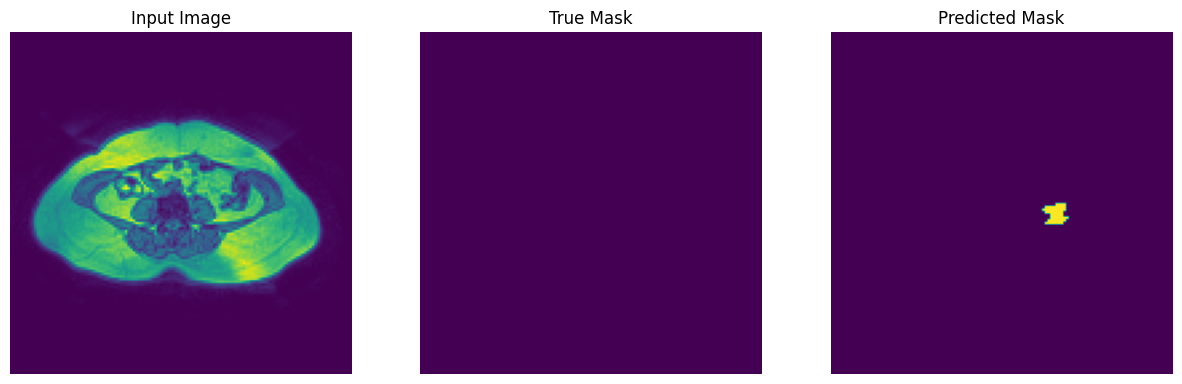

In [23]:
model = build_unet_model()
model.load_weights("chaos19_unet.keras")
show_predictions(test_batches, 20)

# show_predictions(test_batches, 30)